By Ahmad Khoshvaght 401422081 
About HDBSCAN

HDBSCAN is a clustering algorithm based on DBSCAN. The difference is that HDBSCAN uses varying epsilon to find the best stable epsilon. So that HDBSCAN is parameterless and has no challenge over finding the best parameter. HDBSCAN converts DBSCAN into a hierachical clustering. 

In continuation I'm going to explain HDBSCAN with python codes. First I'm going to set up a plotting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

Now im going to initialize some data for it

In [ ]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

Now importing hdbscan and use it on data

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

So now that we have clustered the data -- what actually happened? We can break it out into a series of steps

Transform the space according to the density/sparsity.
Build the minimum spanning tree of the distance weighted graph.
Construct a cluster hierarchy of connected components.
Condense the cluster hierarchy based on minimum cluster size.
Extract the stable clusters from the condensed tree.

Transform The Space
Firstly we need to make our model robust against noises. We need an inexpensive way for that. The simplest way is to fing the distance to kth neighbour. If we have distance matrix (Which we will have to compute it anyway) we can use it. alternatively if our metric is supported (and dimension is low) this is the sort of query that kd-trees are good for. Let's formalise this and (following the DBSCAN, LOF, and HDBSCAN literature) call it the core distance defined for parameter k for a point x and denote as corek(x)
. Now we need a way to spread apart points with low density (correspondingly high core distance). The simple way to do this is to define a new distance metric between points which we will call (again following the literature) the mutual reachability distance. We define mutual reachability distance as follows:

dmreach−k(a,b)=max{corek(a),corek(b),d(a,b)}

where d(a,b) is the original metric distance between a and b. Under this metric dense points (with low core distance) remain the same distance from each other but sparser points are pushed away to be at least their core distance away from any other point.

![Alt text](https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/distance4a.svg)

Build the minimum spanning tree
Now we are going to mark out islands of dense data. We will consider data as a weighted graph with each point as vertices and each edge between them is their distance weighted as their mutual reachability distance. There is a threshold on these weighted edges that if their distance is more than that, the edge will be dropped. This is very expesive approach as there are n2 edges. So we use minimum spanning tree to reduce the time consumption. 

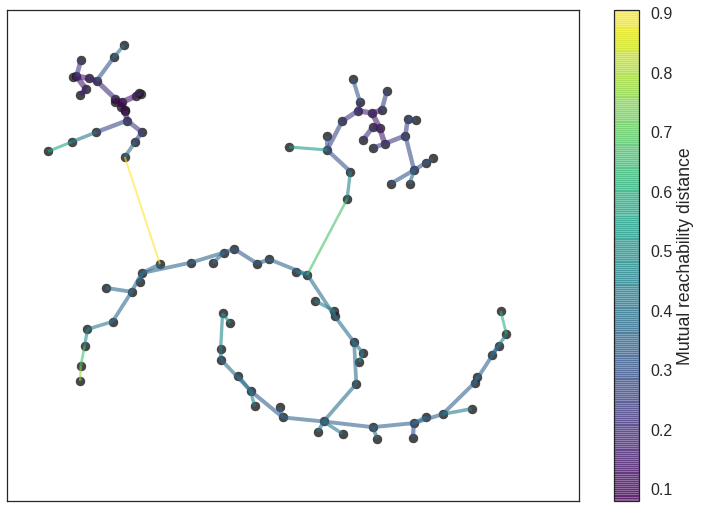

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)

Build the cluster hierarchy
After setting up the minimal spanning tree now we have to convert it into the hierarchy of connected component. This is most easily done by sorting the edges of the tree from lowest to highst and then iterate them through. The tricky part of this is to connect 2 clusters each edge join them together which is done by union-find data structure. The result will be like this:
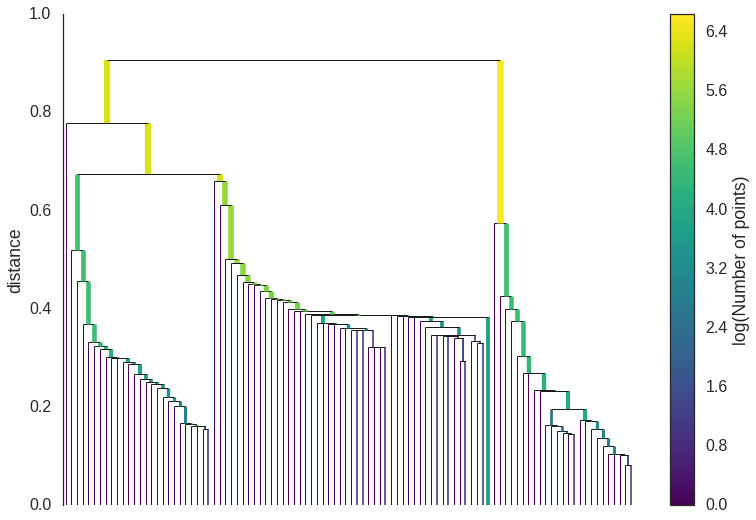

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
